In [1]:
import pandas as pd
import numpy as np
%matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import joblib
%matplotlib inline

Using matplotlib backend: module://matplotlib_inline.backend_inline


In [3]:
np.obj2sctype =  lambda obj: np.dtype(obj).type
import shap

c:\Users\Saheel\Desktop\AI-Powered-Transaction-Fraud-Detection-System-master\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import numpy as np
np.version.version

'2.2.4'

In [6]:
# Load the dataset
df = pd.read_csv('data/bank_transactions_data_2.csv')



In [7]:
# Basic information
print(df.info())
print(df.describe())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            2512 non-null   object 
 1   AccountID                2512 non-null   object 
 2   TransactionAmount        2512 non-null   float64
 3   TransactionDate          2512 non-null   object 
 4   TransactionType          2512 non-null   object 
 5   Location                 2512 non-null   object 
 6   DeviceID                 2512 non-null   object 
 7   IP Address               2512 non-null   object 
 8   MerchantID               2512 non-null   object 
 9   Channel                  2512 non-null   object 
 10  CustomerAge              2512 non-null   int64  
 11  CustomerOccupation       2512 non-null   object 
 12  TransactionDuration      2512 non-null   int64  
 13  LoginAttempts            2512 non-null   int64  
 14  AccountBalance          

In [8]:
# Check for missing values
print(df.isnull().sum())


TransactionID              0
AccountID                  0
TransactionAmount          0
TransactionDate            0
TransactionType            0
Location                   0
DeviceID                   0
IP Address                 0
MerchantID                 0
Channel                    0
CustomerAge                0
CustomerOccupation         0
TransactionDuration        0
LoginAttempts              0
AccountBalance             0
PreviousTransactionDate    0
dtype: int64


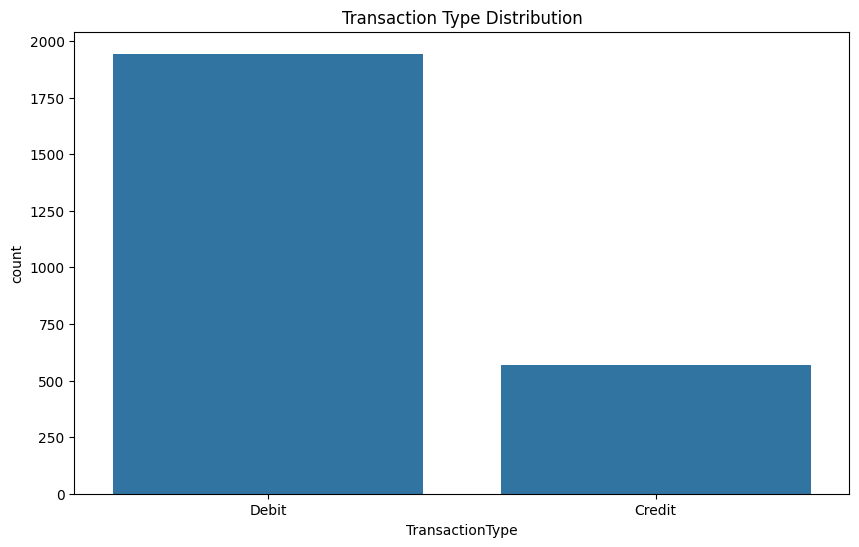

In [9]:
# Transaction type distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='TransactionType', data=df)
plt.title('Transaction Type Distribution')
plt.show()


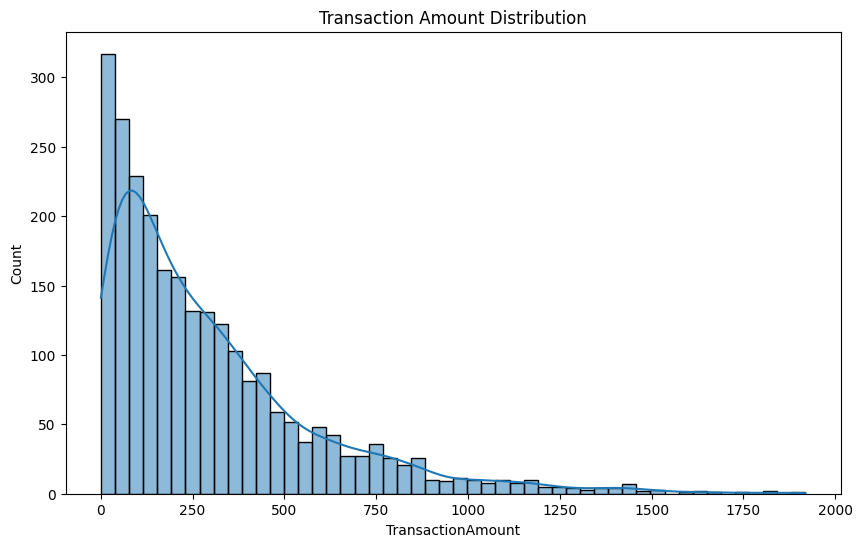

In [10]:
# Transaction amount distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['TransactionAmount'], bins=50, kde=True)
plt.title('Transaction Amount Distribution')
plt.show()


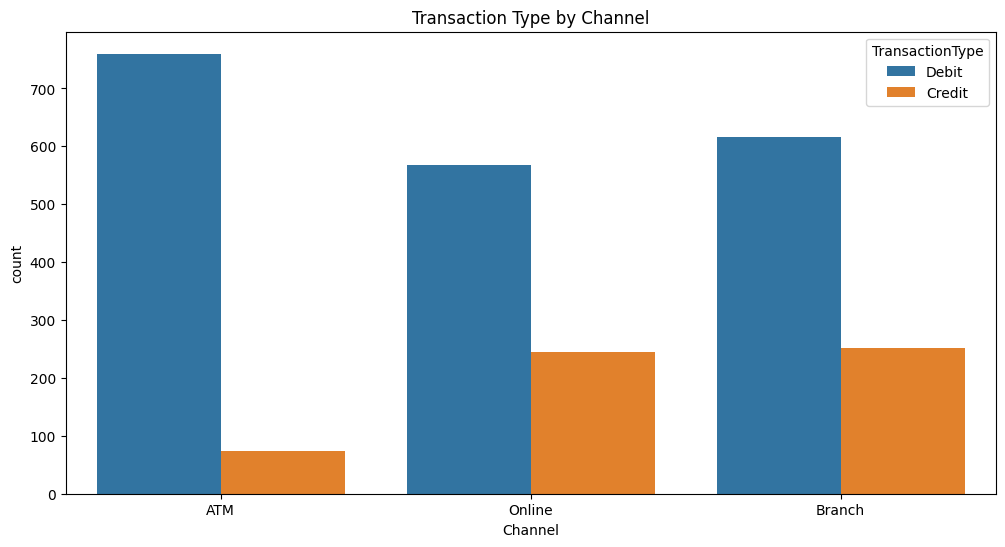

In [11]:
# Device and channel analysis
plt.figure(figsize=(12, 6))
sns.countplot(x='Channel', hue='TransactionType', data=df)
plt.title('Transaction Type by Channel')
plt.show()


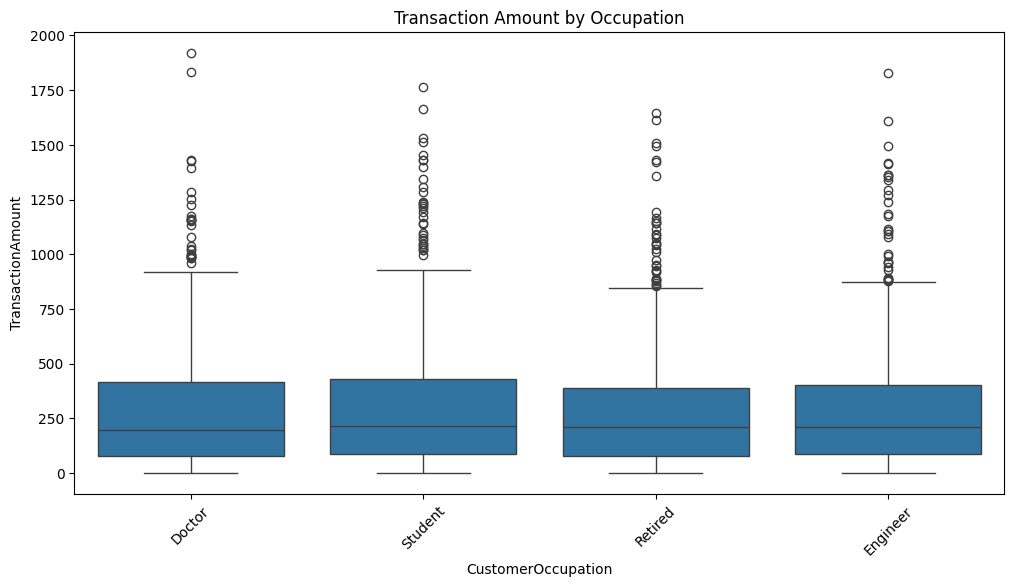

In [12]:
# Customer occupation analysis
plt.figure(figsize=(12, 6))
sns.boxplot(x='CustomerOccupation', y='TransactionAmount', data=df)
plt.title('Transaction Amount by Occupation')
plt.xticks(rotation=45)
plt.show()


In [13]:
# Time-based analysis
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df['Hour'] = df['TransactionDate'].dt.hour
df['DayOfWeek'] = df['TransactionDate'].dt.dayofweek


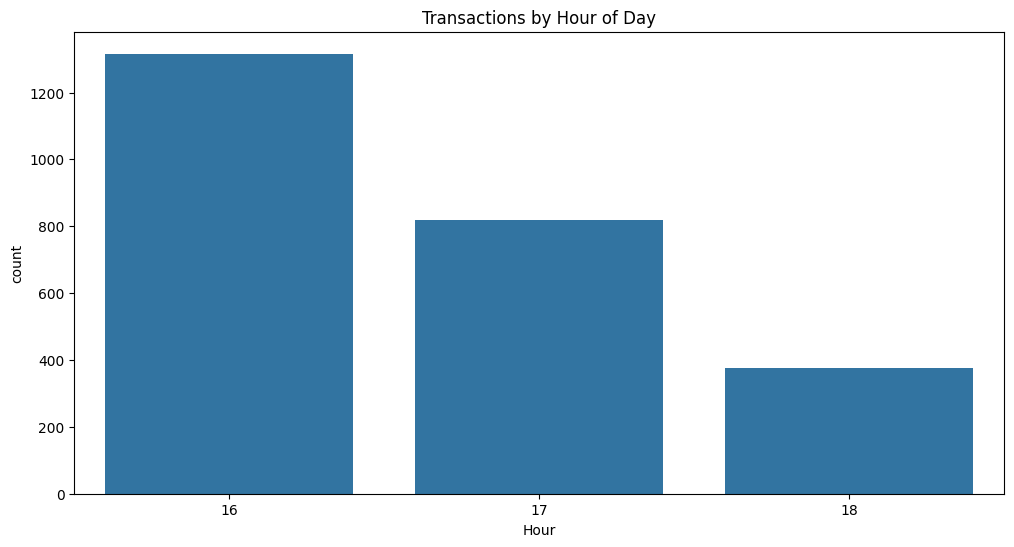

In [14]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Hour', data=df)
plt.title('Transactions by Hour of Day')
plt.show()


Text(0.5, 1.0, 'Account Balance vs Transaction Amount')

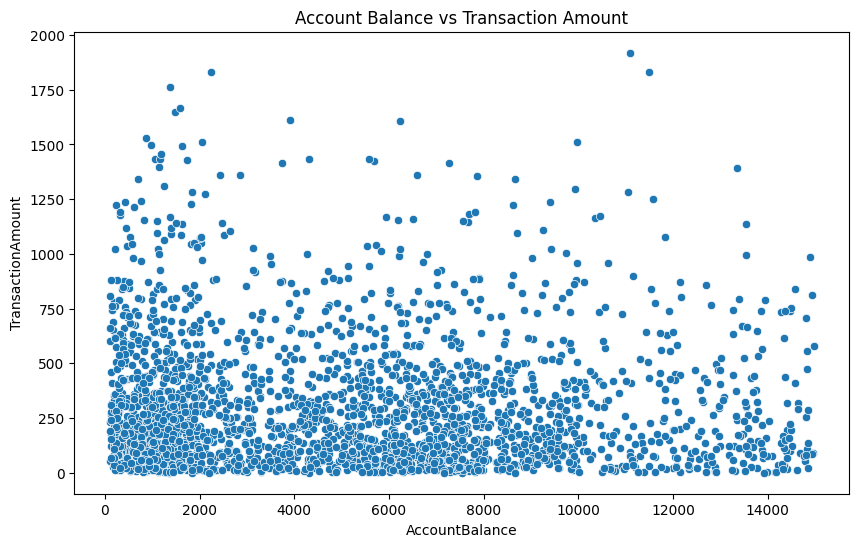

In [15]:

# Account balance vs transaction amount
plt.figure(figsize=(10, 6))
sns.scatterplot(x='AccountBalance', y='TransactionAmount', data=df)
plt.title('Account Balance vs Transaction Amount')

In [16]:
# Create time-based features
# df['DaysSinceLastTransaction'] = (pd.to_datetime('2024-11-04') - df['PreviousTransactionDate']).dt.days
# df['TransactionSpeed'] = df['TransactionAmount'] / df['TransactionDuration']
# Ensure PreviousTransactionDate is in datetime format
df['PreviousTransactionDate'] = pd.to_datetime(df['PreviousTransactionDate'])

# Create time-based features
df['DaysSinceLastTransaction'] = (pd.to_datetime('2024-11-04') - df['PreviousTransactionDate']).dt.days

# Avoid divide-by-zero for TransactionDuration
df['TransactionSpeed'] = df['TransactionAmount'] / df['TransactionDuration'].replace(0, np.nan)


In [17]:
# Create behavioral features
customer_stats = df.groupby('AccountID').agg({
    'TransactionAmount': ['mean', 'std', 'max'],
    'TransactionDuration': 'mean',
    'Location': 'nunique'
}).reset_index()
customer_stats.columns = ['AccountID', 'AvgAmount', 'StdAmount', 'MaxAmount', 'AvgDuration', 'UniqueLocations']

In [18]:
df = pd.merge(df, customer_stats, on='AccountID', how='left')

In [19]:
# Create anomaly features
df['AmountDeviation'] = (df['TransactionAmount'] - df['AvgAmount']) / df['StdAmount']
df['DurationDeviation'] = (df['TransactionDuration'] - df['AvgDuration']) / df['AvgDuration']

In [20]:
# Encode categorical variables
label_encoders = {}
categorical_cols = ['TransactionType', 'Location', 'DeviceID', 'MerchantID', 'Channel', 
                   'CustomerOccupation']

In [21]:
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

In [22]:
# Since we don't have labeled fraud data, we'll simulate it
# In a real scenario, you would use actual fraud labels
np.random.seed(42)
df['IsFraud'] = np.random.randint(0, 100, size=len(df)) < 2  # ~2% fraud rate

In [23]:
# Features and target
features = ['TransactionAmount', 'TransactionDuration', 'LoginAttempts', 
            'AccountBalance', 'DaysSinceLastTransaction', 'TransactionSpeed',
            'AvgAmount', 'StdAmount', 'MaxAmount', 'AvgDuration', 'UniqueLocations',
            'AmountDeviation', 'DurationDeviation'] + categorical_cols

In [24]:
X = df[features]
y = df['IsFraud']

In [25]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [26]:
# 1. Isolation Forest (Unsupervised Anomaly Detection)
iso_forest = IsolationForest(n_estimators=100, contamination=0.02, random_state=42)
iso_forest.fit(X_train)
joblib.dump(iso_forest, 'models/isolation_forest.pkl')

['models/isolation_forest.pkl']

In [27]:
# 2. Random Forest (Supervised)
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
joblib.dump(rf, 'models/random_forest.pkl')

['models/random_forest.pkl']

In [28]:
# 3. XGBoost (Supervised)
xgb = XGBClassifier(n_estimators=100, random_state=42, scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train))
xgb.fit(X_train, y_train)
joblib.dump(xgb, 'models/xgboost.pkl')

['models/xgboost.pkl']

In [29]:
# Evaluate models
def evaluate_model(model, X_test, y_test, model_name):
    if hasattr(model, 'predict_proba'):
        y_pred = model.predict_proba(X_test)[:, 1]
        y_pred_class = (y_pred > 0.5).astype(int)
    else:  # For IsolationForest
        y_pred = -model.decision_function(X_test)  # Higher score = more anomalous
        y_pred_class = (y_pred > np.percentile(y_pred, 98)).astype(int)
    
    print(f"\n{model_name} Performance:")
    print(confusion_matrix(y_test, y_pred_class))
    print(classification_report(y_test, y_pred_class))
    if hasattr(model, 'predict_proba'):
        print(f"ROC AUC: {roc_auc_score(y_test, y_pred)}")


In [30]:
evaluate_model(iso_forest, X_test, y_test, "Isolation Forest")
evaluate_model(rf, X_test, y_test, "Random Forest")
evaluate_model(xgb, X_test, y_test, "XGBoost")



Isolation Forest Performance:
[[480  11]
 [ 12   0]]
              precision    recall  f1-score   support

       False       0.98      0.98      0.98       491
        True       0.00      0.00      0.00        12

    accuracy                           0.95       503
   macro avg       0.49      0.49      0.49       503
weighted avg       0.95      0.95      0.95       503


Random Forest Performance:
[[491   0]
 [ 12   0]]
              precision    recall  f1-score   support

       False       0.98      1.00      0.99       491
        True       0.00      0.00      0.00        12

    accuracy                           0.98       503
   macro avg       0.49      0.50      0.49       503
weighted avg       0.95      0.98      0.96       503

ROC AUC: 0.548031228784793

XGBoost Performance:
[[490   1]
 [ 12   0]]


c:\Users\Saheel\Desktop\AI-Powered-Transaction-Fraud-Detection-System-master\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Saheel\Desktop\AI-Powered-Transaction-Fraud-Detection-System-master\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Saheel\Desktop\AI-Powered-Transaction-Fraud-Detection-System-master\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples

              precision    recall  f1-score   support

       False       0.98      1.00      0.99       491
        True       0.00      0.00      0.00        12

    accuracy                           0.97       503
   macro avg       0.49      0.50      0.49       503
weighted avg       0.95      0.97      0.96       503

ROC AUC: 0.5431093007467753


In [ ]:
# SHAP explainability
# SHAP explainability (optional)
try:
    explainer = shap.Explainer(xgb, X_train)
    shap_values = explainer(X_train)
except Exception as e:
    print("SHAP skipped due to compatibility issue:", e)
    explainer = None


SHAP skipped due to compatibility issue: The passed model is not callable and cannot be analyzed directly with the given masker! Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)


In [34]:
# Save SHAP explainer
joblib.dump(explainer, 'models/shap_explainer.pkl')

['models/shap_explainer.pkl']

In [35]:
import os
import joblib

os.makedirs("trained_models", exist_ok=True)

joblib.dump(iso_forest, "trained_models/isolation_forest.pkl")
joblib.dump(xgb, "trained_models/xgboost.pkl")

print("Models saved successfully")


Models saved successfully
